In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

In [2]:
# Load the data
import pandas as pd

options_data = pd.read_csv('combined_data.csv')

# Convert Unix timestamp to readable datetime format
options_data['timestamp'] = pd.to_datetime(options_data['timestamp'], unit='ms')

# Set the timestamp as the index for easier time-based operations
options_data.set_index('timestamp', inplace=True)

# Separate data by each symbol (contract)
symbol_groups = options_data.groupby('symbol')

# Display basic information with sorted data
for symbol, group in symbol_groups:
    # Sort the group by the index (timestamp) and optionally by another column (e.g., 'strike_price')
    sorted_group = group.sort_index()  # Automatically sorts by the timestamp index

    print(f"\nData for symbol: {symbol}")
    print(sorted_group.head())  # Display the first few rows for each symbol

# Save the cleaned and sorted data with timestamp as the index
options_data.to_csv("options_data.csv")
print("Cleaned 5-minute data saved to options_data.csv")



Data for symbol: O:SPXW241101C05620000
                                    symbol    open    high     low   close  \
timestamp                                                                    
2024-10-29 17:20:00  O:SPXW241101C05620000  226.28  226.28  226.28  226.28   
2024-10-31 17:30:00  O:SPXW241101C05620000  109.61  109.61  109.61  109.61   
2024-10-31 19:15:00  O:SPXW241101C05620000  113.80  113.80  112.20  112.20   
2024-10-31 19:55:00  O:SPXW241101C05620000  102.05  102.05   90.45   90.45   
2024-10-31 20:05:00  O:SPXW241101C05620000   98.83   98.83   98.83   98.83   

                     volume  transactions  
timestamp                                  
2024-10-29 17:20:00       1             1  
2024-10-31 17:30:00       1             1  
2024-10-31 19:15:00       2             2  
2024-10-31 19:55:00       9             3  
2024-10-31 20:05:00       5             1  

Data for symbol: O:SPXW241101C05640000
                                    symbol    open    high     lo

In [3]:
# # Load the data
# options_data = pd.read_csv('combined_data.csv')

# # Convert Unix timestamp to readable datetime format
# options_data['timestamp'] = pd.to_datetime(options_data['timestamp'], unit='ms')

# # Separate data by each symbol (contract)
# symbol_groups = options_data.groupby('symbol')



# # Display basic information
# for symbol, group in symbol_groups:
#     print(f"\nData for symbol: {symbol}")
#     print(group.head())  # Display the first few rows for each symbol

In [4]:

# # Loop through each symbol and plot its price trends
# for symbol, group in symbol_groups:
#     plt.figure(figsize=(10, 6))
#     plt.plot(group['timestamp'], group['close'], label='Close Price')
#     plt.plot(group['timestamp'], group['open'], label='Open Price', linestyle='--')
    
#     plt.title(f'Price Trend for {symbol}')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


In [5]:
# # Loop through each symbol and plot volume and transaction patterns
# for symbol, group in symbol_groups:
#     plt.figure(figsize=(12, 6))

#     # Volume plot
#     plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
#     plt.plot(group['timestamp'], group['volume'], color='blue', label='Volume')
#     plt.title(f'Volume and Transactions for {symbol}')
#     plt.xlabel('Date')
#     plt.ylabel('Volume')
#     plt.legend()
#     plt.grid(True)

#     # Transactions plot
#     plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
#     plt.plot(group['timestamp'], group['transactions'], color='orange', label='Transactions')
#     plt.xlabel('Date')
#     plt.ylabel('Transactions')
#     plt.legend()
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()

In [6]:
# # Set the window size for rolling volatility (e.g., 12 intervals for an hour)
# window_size = 9

# # Loop through each symbol, calculate log returns, and rolling volatility
# for symbol, group in symbol_groups:
#     # Sort by timestamp in case it's not ordered
#     group = group.sort_values(by='timestamp')
    
#     # Calculate log returns for close prices
#     group['log_return'] = np.log(group['close'] / group['close'].shift(1))
    
#     # Calculate rolling volatility (standard deviation of log returns)
#     group['rolling_volatility'] = group['log_return'].rolling(window=window_size).std() * np.sqrt(252*78)
#     # * np.sqrt(252*78) annualizes volatility assuming 252 trading days and 78 intervals per day
    
#     # Plot the rolling volatility
#     plt.figure(figsize=(10, 6))
#     plt.plot(group['timestamp'], group['rolling_volatility'], label='Rolling Volatility')
#     plt.title(f'Rolling Volatility for {symbol}')
#     plt.xlabel('Date')
#     plt.ylabel('Annualized Volatility')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


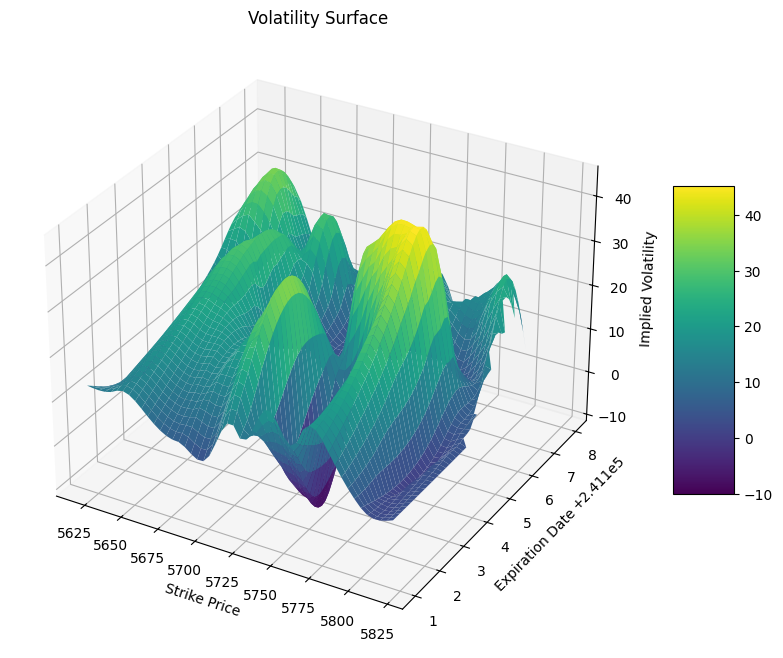

In [7]:


# Prepare lists for interpolation data
strike_prices = []
exp_dates = []
volatilities = []

# Set rolling volatility window size (12 intervals for 1 hour)
window_size = 9

# Calculate rolling volatility and prepare data for interpolation
for symbol, group in symbol_groups:
    # Sort by timestamp to ensure correct order
    group = group.sort_values(by='timestamp')

    # Calculate log returns
    group['log_return'] = np.log(group['close'] / group['close'].shift(1))
    
    # Calculate rolling volatility (annualized)
    group['rolling_volatility'] = group['log_return'].rolling(window=window_size).std() * np.sqrt(252*78)
    
    # Extract strike price and expiration date from symbol
    strike = int(symbol.split("P")[-1].split("C")[-1][:5])
    expiration_date = symbol[6:12]  # YYMMDD format
    
    # Collect data points with valid rolling volatility
    valid_data = group.dropna(subset=['rolling_volatility'])
    for _, row in valid_data.iterrows():
        strike_prices.append(strike)
        exp_dates.append(expiration_date)
        volatilities.append(row['rolling_volatility'])

# Convert lists to arrays for interpolation
strike_prices = np.array(strike_prices)
exp_dates = np.array([int(date) for date in exp_dates])
volatilities = np.array(volatilities)

# Create grid for interpolation
strike_grid, exp_date_grid = np.meshgrid(
    np.linspace(strike_prices.min(), strike_prices.max(), 50),
    np.linspace(exp_dates.min(), exp_dates.max(), 50)
)

# Interpolate volatility data
volatility_grid = griddata(
    (strike_prices, exp_dates), volatilities,
    (strike_grid, exp_date_grid), method='cubic'
)

# Plot the volatility surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(strike_grid, exp_date_grid, volatility_grid, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Expiration Date')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()
